# Image Classification with CNN using Tensorflow
Author: Mason Phung

Project goals:
- Focus on convolutional neural network (CNN) technology.
- Build a CNN machine learning model that can classify the images reliably with good accuracy.
- Training different CNN models including self-built and pre-trained to find the most suitable-efficient model for the task.

Last update: November 2024

![example](docs/figures/example_images.png)

In [1]:
# Load libraries
import pandas as pd
import glob
import plotly.express as px
from src import config, utils
from src.test import test_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# I. Data exploration and preparation

- The dataset used in the work is Intel Image Classification from Kaggle: https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download
- The data has been divided into train/pred/test sets.
- After downloading them, we'll extract the zip file, then directly access the unzip folder.
- The images are pre-processed already, so we'll only need to explore it then use it directly for training.

## A. Exploration

### **1. Determine all the image classes of the dataset.**

Class names are extracted using `os.listdir()` function

In [ ]:
# Assign the location path of the dataset
# Assign the location path of the dataset
data_path = config.data_path

# Set the dataset paths
train_path = config.train_path
test_path = config.test_path
pred_path = config.pred_path

# Determine frequently used constants
image_size = config.image_size
img_height = config.img_height
img_width = config.img_width
img_channels = config.img_channels
batch_size = config.batch_size
class_names = config.class_names
print("All classes found in the directory:", class_names)

All classes found in the directory: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


### **2. Let's take a look at some images in the train set**

- Observe some instances to see how the images of all the labels look like.
- Loop through each class to randomly generate an example image.

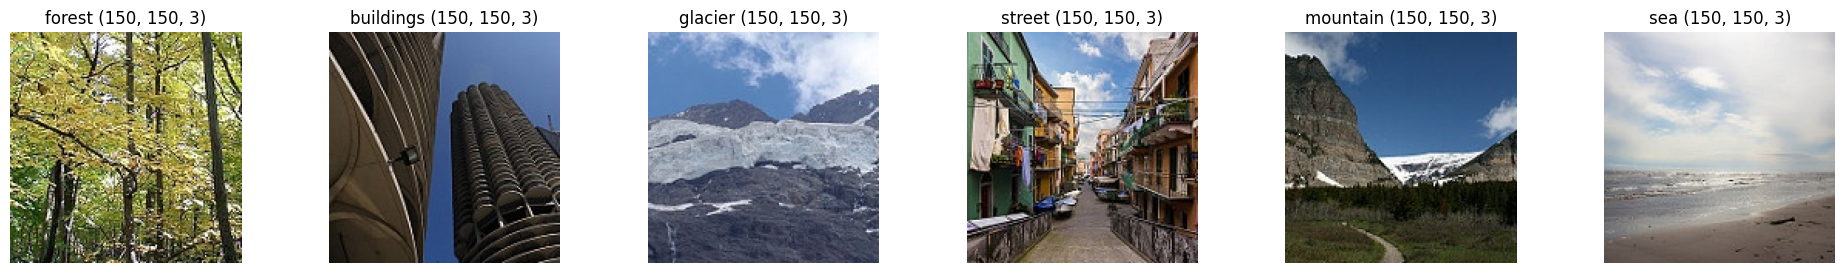

In [2]:
utils.display_images(num_images=6, target_classes='all')

<span style="color:red">

*We can see that some `glacier` and `mountain` images are pretty similar as their images usually have mountains. It is important to note this as it could be a problem for the classification model.*

</span>

### **3. Determine the number of images in the training and test sets for each class name.**

In [4]:
for count, each in enumerate(class_names):
    # Count the total training & test image of each class
    x = len(glob.glob(f'{train_path}/{each}/*'))
    y = len(glob.glob(f'{test_path}/{each}/*'))
    # Print the results
    print(
        f"Class: {each}","\n",
        "Number of train images: ", x,"\n",
        "Number of test images: ", y ,"\n",
        "Ratio: ", round((y/(x+y)), 2),"\n"
    )

Class: forest 
 Number of train images:  2271 
 Number of test images:  474 
 Ratio:  0.17 

Class: buildings 
 Number of train images:  2191 
 Number of test images:  437 
 Ratio:  0.17 

Class: glacier 
 Number of train images:  2404 
 Number of test images:  553 
 Ratio:  0.19 

Class: street 
 Number of train images:  2382 
 Number of test images:  501 
 Ratio:  0.17 

Class: mountain 
 Number of train images:  2512 
 Number of test images:  525 
 Ratio:  0.17 

Class: sea 
 Number of train images:  2274 
 Number of test images:  510 
 Ratio:  0.18 



<span style="color:red">

- *There are not many differences between the proportion of train/test sets between each class. Notice that class `glacier` as a slight bigger amount of test images compared to other classes.*
- *We have a balance data set as the counts of each class in the train set are quite similar.*

</span>

## B. Data Preparation

1. Use TensorFlow's `image_dataset_from_directory` to generate datasets for training, validation, and test. We'll following options:

        - Image size: 150 x 150 and 3 channels
        - Colour mode = RGB
        - Shuffle = True
        - Seed = 1234
        - Labels = inferred
        - Class names = class_names
        - Label mode = int
        - Batch size = 32

    - We set the image size, colour mode to match the properties of the images.
    - Set the class names of the images, use the label mode as integer, set `labels = inferred` as we get the labels from the folder names (in the directory).
    - Use a batch size of 32.

2. Normalize images

        image = tf.cast(image / 255. ,tf.float32)
    - Convert it from 0-255 to 0-1 range, which 

In [7]:
%run src/data_process.py

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


# II. Model training & testing

- I trained all the models locally on my M2 mac.
- Use `tensorflow-metal` to train using its GPU.


## A. Self-built Convolution Neural Network

Observe model architecture, source code at `src/cnn_model.py`

In [ ]:
# Only for reference
def build_model():
    """
    Returns a compiled keras neural network model
    
    Returns:
        model (keras.models.Sequential): The constructed & compiled Keras model.
    """
    # Build model architecture
    model = keras.models.Sequential([
        Input(shape=(img_height, img_width, img_channels)),
        # Data augmentation layer
        RandomFlip('horizontal'),
        RandomRotation(0.2),
        RandomZoom(0.3),
        
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        Dropout(rate=0.2),
        
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        Dropout(rate=0.3),
        
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        Dropout(rate=0.4),
        
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        Dropout(rate=0.5),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(units=512, activation='relu'),
        Dropout(rate=0.5),
        Dense(units=len(class_names), activation='softmax')
    ])


    # Compile with suitable parameters
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.001),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics = ['accuracy']
    )
    return model

- My training/architecture building progress from scratch:
    - First train a Conv2D model with a few simple Conv2D + MaxPooling2D layers and a Flatten + Output layer. Note that keeps each `Conv2D` followed by a `MaxPooling2D` layer.
    - Then, aims to improve the model's reliability and reduce overfitting by adding aditional layers and tuning different metrics. It can be achieved by:
        - Increase model complexity: Adding more layers to the model (Conv2D, MaxPooling2D, Dense). This make the model better understand the data, especially the training data.
        - Adding Dropout layers to help the model to not rely on any specific neuron, reduce overfitting. We'll increase the dropout rate for layers that have a higher number of filters.
        
    - For Conv2D layers:
        - Initially used 4 layers of `32-64-128-256 filters`, then I increased these numbers but it doesn't work. Then come back to the original numbers of filters but doubled the number of layers.
        - Apply similar `kernel_size = 3`, the model doesn't seem to improve when kernel size changed.
        - Use `activation = 'relu'` as it's suitable for our data and `padding = 'same'` to keep the layer's outputs having the same spatial dimensions as its inputs. Also this will make sure that we will not drop any input just because the number of inputs is odd.
    - Keep the same MaxPooling2D with pool_size = (2,2) as this is the ideal value, it will not reduce our data.
    - Using `softmax` output activation function as we are classifying multiclasses.

- I tried to overcome underfitting (model works badly on both train/val set), overfitting (model works well on train set but not on val set) by balancing between model complexity and dropout/data augmentation when tuning the model.
- Note that even though I made different tuning attempts to achieve better results, I'll just show the best version to save time.
- I also refer keras_tuner results of hyperparameters tuning. This hp tuned model can be seen in later sections.

**Set up data augmentation**

- To help increase the accuracy score, it is better to increase the number of data we have. Utilizing data augmentation certainly helps achieving it.
- Data augmentation randomly transforms the existing images, create new instances of the images based on the ones we have.
- We will do random horizontal flip, rotation and zoom to the images.


**Set up early stopping**

To save resources, it is important to stop the training when the model is no longer working fine. We determine this using `val_loss`, which is the loss of the model on the validation set. If the loss increases, after a certain of epochs, the model will stop training.
- Evaluation the loss of validation data with `val_loss`.
- Set `min_delta = 0`: Look at the loss when it gets worse.
- `Patience = 3`: Stop at the number of epochs after the loss starts to get worse.

**Compiling model**
- Choose Adam optimizers for its efficiency and learning rate at 0.001 (As it is the best training rate after many trials).
- Choose `SparseCategoricalCrossentropy()` as our loss function because (1) `Categorical` - we are classifying a categorical variable, (2) we have multiple classes - `Crossentropy`, (3) our classes were inputed as integers during the data processing step - `Sparse`.
- Choose `Accuracy` as metric as we want to measure the percentage of correctly classified samples. It's also suitable because our classes are balance.


In [ ]:
%run src/train

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.2167 - loss: 1.7271 - val_accuracy: 0.4387 - val_loss: 1.4137
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.4274 - loss: 1.3782 - val_accuracy: 0.5346 - val_loss: 1.2226
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.4942 - loss: 1.2348 - val_accuracy: 0.5706 - val_loss: 1.1345
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.5334 - loss: 1.1701 - val_accuracy: 0.5880 - val_loss: 1.1000
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 130ms/step - accuracy: 0.5615 - loss: 1.1241 - val_accuracy: 0.5980 - val_loss: 1.0813
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.5678 - loss: 1.1010 - val_accuracy: 0.6297 - val_loss: 1.0071
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 190ms/step - accuracy: 0.5884 - loss: 1.0639 - val_accuracy: 0.6383 - val_loss: 0.9840
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.5924 - loss: 1.05

Model saved!
Traing results saved!
Model trained successfully!


<span style="color:red">

The training output of decreasing `loss` indicates a steady improvement in both training and validation performance over time, which is a good sign that the model is learning effectively.

Training Performance
- Accuracy: It increases steadily, starting from 21.67% in epoch 1 and reaching 79.10% by epoch 44.
- Loss: Training loss decreases consistently, demonstrating that the model is optimizing its weights.

Validation Performance
- Accuracy: Gradually improves, starting from 43.87% and stabilizing around 78-79% in later epochs.
- Loss: Validation loss consistently decreases and stabilizes around epoch 40, indicating the model generalizes well to the validation set.

Notable Trends
1.	**No Overfitting Observed Yet**: Both training and validation metrics improve in tandem without significant divergence, implying the model is not overfitting.
2.	**Stabilization**: Around epoch 40, validation metrics (loss and accuracy) start to plateau, which might signal that the model has nearly reached its optimal performance on the validation set.

</span>

**Model architecture plot**

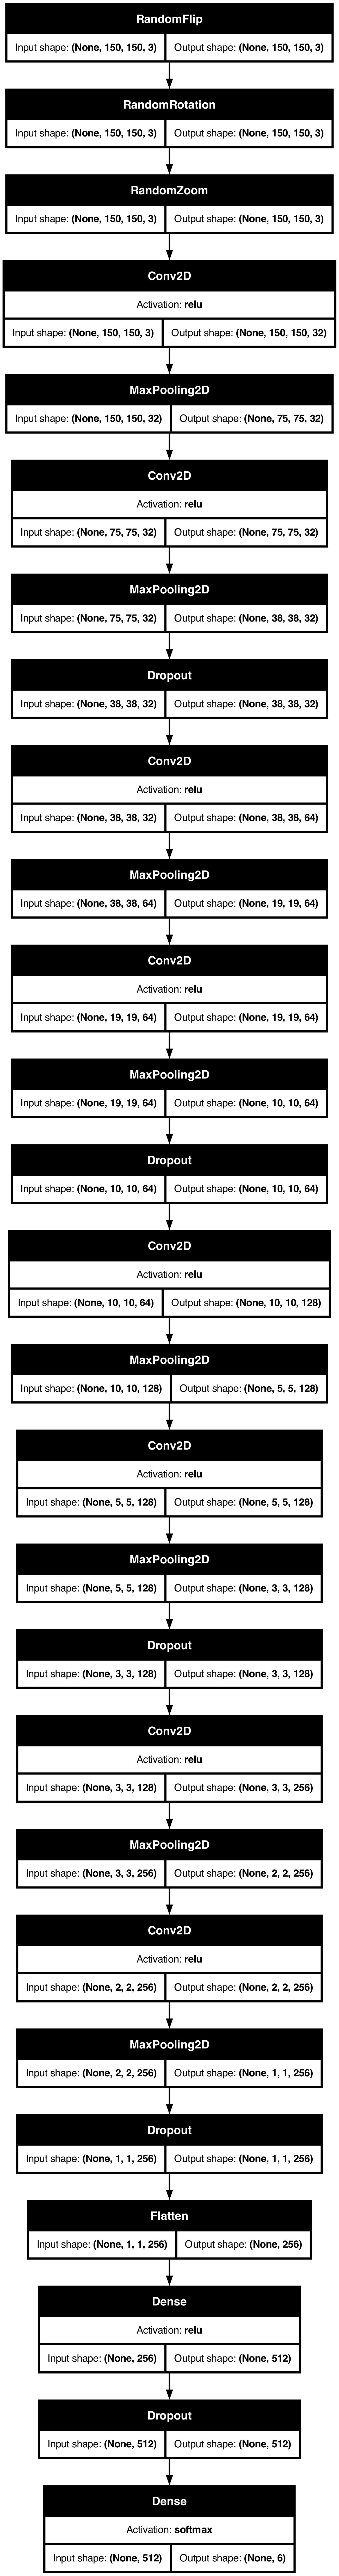

In [6]:
cnn_model = load_model('models/cnn_model.h5')
plot_model(
    cnn_model, 
    to_file='models/cnn_model.png',
    show_shapes=True,
    show_layer_activations=True
)

**A fine tuned keras_tuner version.**

A fine-tuned version of this model could be found in `src/tune.py` and `models/fine_tuned_cnn.h5`. 

We tune the number of layers and the number of Conv2D layers inside it. Let's call the large layer 'batch' and layers inside each batch 'layers'. Use `keras-tuner` and tune among these parameters:
- Number of batches (1-5 batches)
- Number of hidden layers (1-5 layers)
- Conv2D layers:
    - The size of filters (32-256)
    - Kernel size (3 or 5)
- Dense layers: Sizes of hidden layers (32-512 units)
- Dropout rate (0 - 0.9)
- Learning rate (1e-4 - 1e-2)

The rest of the hyperparameters are set based on the properties of the data. Utilize Bayesian Optimization to search for the best hyperparamters. 

**Let's test the model with the test set and evaluate through error analysis**

Model cnn_model loaded!
Evaluating the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.8015 - loss: 0.5849
Test accuracy of the model: 0.800000011920929


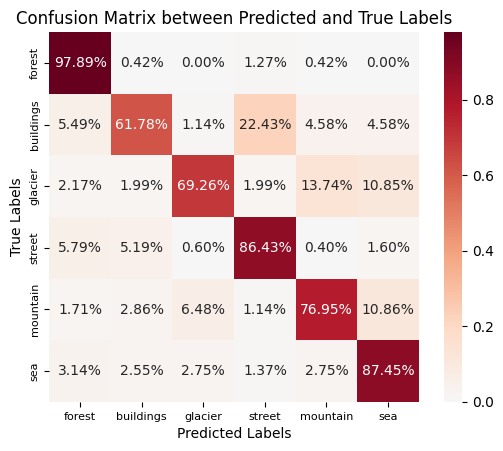

Most misclassified pair: Misclassified True Label: buildings as Predicted Label: street
Number of mislabeled images for buildings predicted as street: 98


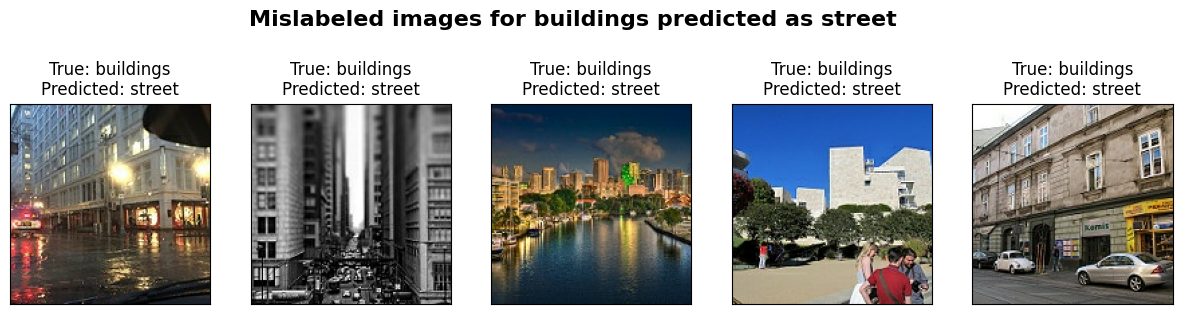

In [ ]:
test_model(model_name="cnn_model")

<span style="color:red">

**Comments**

- Observing the confusion matrix, the model has a ok-good prediction for most of the labels, with the highest accuracy for `forest`(97.89%) and `sea`(87.45%).
- There seems to be a problem when predicting `buildings`, with only 61.8% accuracy. When predicting this label, it mostly misclassified it with `street`.
- The number of wrong cases also increase when the model classifying between `glacier-mountain`, `glacier-sea` and `mountain-sea`.
- Take a look at some examples of the mislabeled cases, the model seems to misunderstand the whole meaning of the images. In each image, we can see that the predicted label object can be seen in the image, but it does not cover the main subject/topic of the picture.

</span>

**Suggestion**

- Increase in the size of training data would be beneficial for the model as it helps the model to have more knowledge and better recognize the pattern of each label.
- Additional augmentation layers could also help the model to increase the performance. For example, tuning brightness, crop, zoom, resize,...
- Notice how the model seems to learn slower after epoch 40, we can set dynamic learning rate with `ReduceLROnPlateau`, which will increase/decrease th learning rate when required.

## B. Use pre-trained models

I decided to use 3 pre-trained models: Mobilenet, VGG16 and resnet50; for these reasons:
- All models are suitable with image classification tasks and can be easily accessed.
- **Mobilenet**: Popular for its small size (16MB), a low number of parameters (4.3M) and the ability to save computational resources but maintaining efficiency and performance. Main goal: Determine whether if this model is sufficient for this classification task. As using this would save training time and computational resources.
- **resnet50**: Known for its strong performance in various tasks and require minimum fine-tuning. Has a reasonable training speed (not as fast as lightweight models due to its depth - 107 layers), but still faster than other similar depth models. Main goal: Determine if this model is the best for this task or it's better to use other models.
- **VGG16**: Compared to other two models, this model is quite heavy (528MB) with a lot of parameters (138.4M parameters -uniform architecture), which could lead to a slow training speed. Main goal: Use this model mainly for comparison, to determine the best model for this task.

### **Mobilenet model**

**Train model**
- Apply data augmentation, pre-trained MobileNet model with correct classification layer, then an output layer.
- Freeze MobileNet weight with `trainable = False` to prevent catastrophic forgetting.

In [ ]:
# Only for reference
from tensorflow.keras.applications import MobileNet
def build_model():
    """
    Returns a compiled keras neural network model
    
    Returns:
        model (keras.models.Sequential): The constructed & compiled Keras model.
    """
    # Create a pre-trained mobilenet model instance
    mobilenet_model = MobileNet(
        weights = "imagenet",
        input_shape = (img_height, img_width, img_channels),
        include_top = False,
        pooling = "avg"
    )

    for layer in mobilenet_model.layers:
        layer.trainable = False

    mobile_model = keras.models.Sequential([
        # Input layer
        Input(shape = (img_height, img_width, img_channels)),
        # Data augmentation
        RandomFlip('horizontal'),
        RandomRotation(0.1),
        RandomZoom(0.2),
        # MobileNet model
        mobilenet_model,
        # Output layer
        Dense(len(class_names), activation = 'softmax')
    ])

    mobile_model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
        metrics = ['accuracy']
    )
    return mobile_model

Select a model to train:
1: cnn_model
2: mobilenet_model
3: vgg19_model
4: resnet50_model
mobilenet_model
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 62s 170ms/step - accuracy: 0.7232 - loss: 0.7426 - val_accuracy: 0.8806 - val_loss: 0.3267
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - accuracy: 0.8760 - loss: 0.3457 - val_accuracy: 0.8849 - val_loss: 0.3284
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.8908 - loss: 0.3019 - val_accuracy: 0.8849 - val_loss: 0.3187
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.8947 - loss: 0.2960 - val_accuracy: 0.8963 - val_loss: 0.2963
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.8990 - loss: 0.2849 - val_accuracy: 0.8842 - val_loss: 0.3205
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 169ms/step - accuracy: 0.8967 - loss: 0.2820 - val_accuracy: 0.8924 - val_loss: 0.2942
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.9050 - loss: 0.2657 - val_accuracy: 0.8

Model saved at models/mobilenet_model.h5!
The accuracy plot of the model:



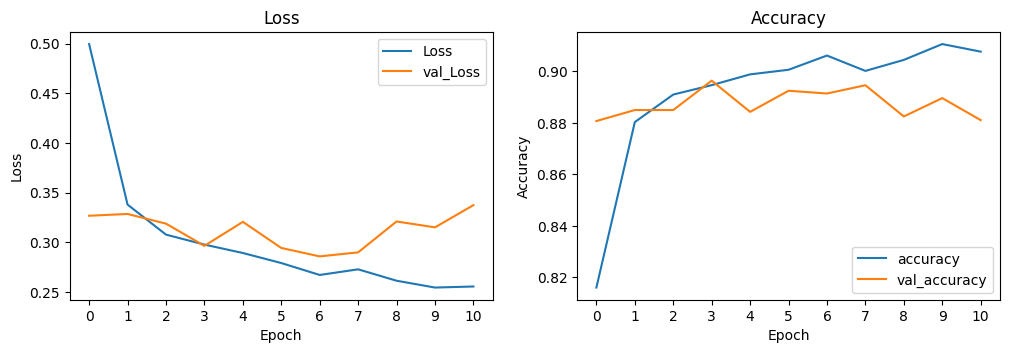

Model trained successfully!


In [ ]:
# train mobilenet model
%run src/train

<span style="color:red"> 

- The accuracy and loss plot shows a good result. The model seems to have a stable accuracy >0.88 in average on validation set.
- There is a slight overfitting but this is small and should not be a considerable issue.

</span>

**Model architecture plot**

As we are using similar training architecture for pre-trained models, the rest of the model should have the same architecture plot as this printed plot.

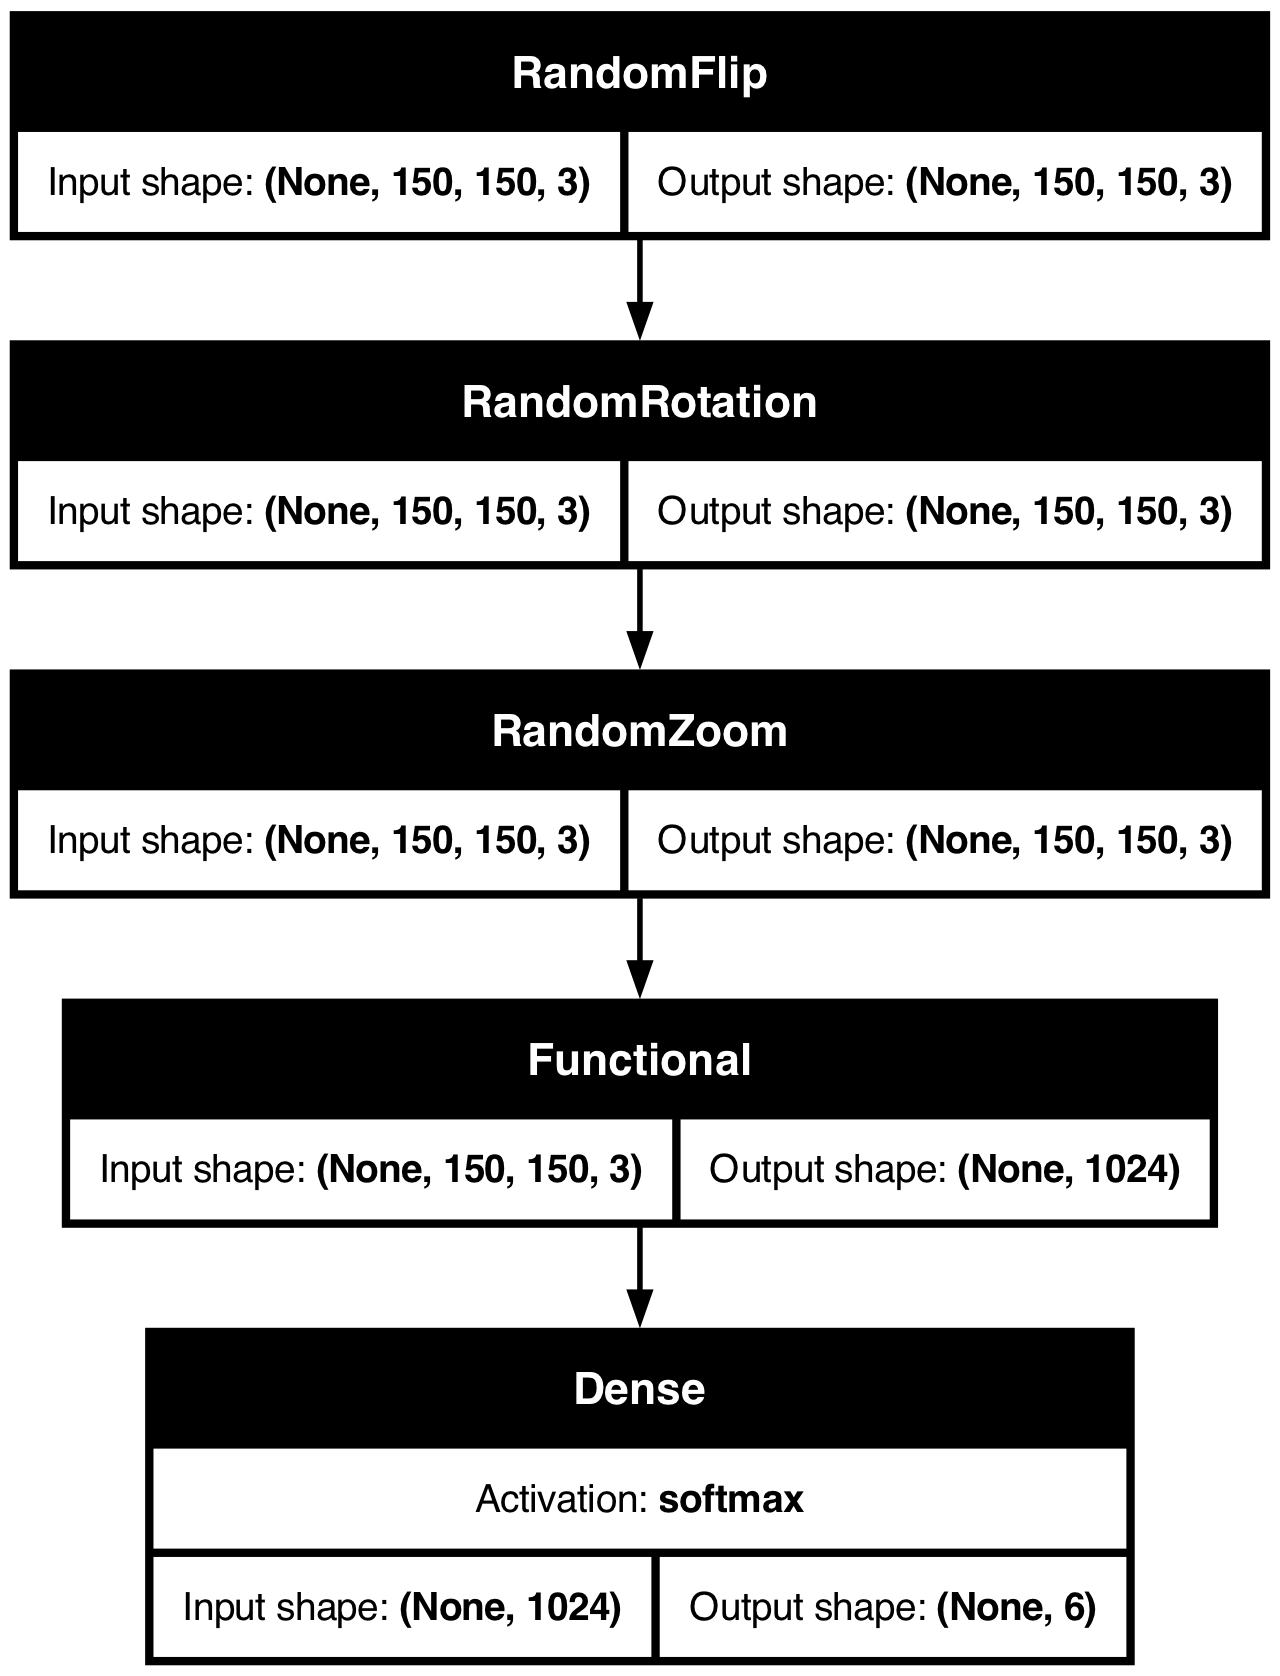

In [6]:
mobilenet_model = load_model('models/mobilenet_model.h5')
plot_model(
    mobilenet_model, 
    to_file='models/mobilenet_model.png',
    show_shapes=True,
    show_layer_activations=True
)

**Model testing & Error analysis**

Model mobilenet_model loaded!
Evaluating the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8917 - loss: 0.3002
Test accuracy of the model: 0.8960000276565552


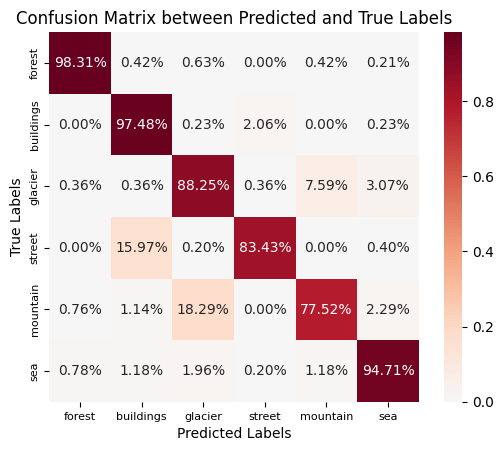

Most misclassified pair: Misclassified True Label: mountain as Predicted Label: glacier
Number of mislabeled images for mountain predicted as glacier: 96


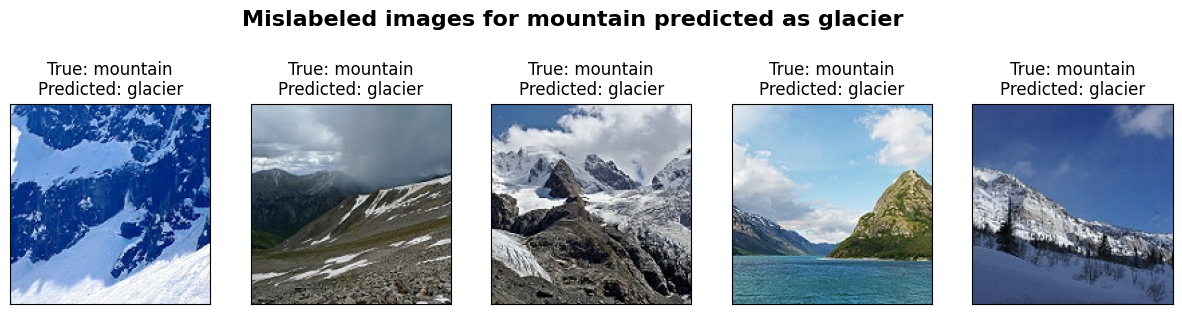

In [ ]:
test_model(model_name="mobilenet_model")

Let's print some true glacier examples to see what true glaciers look like

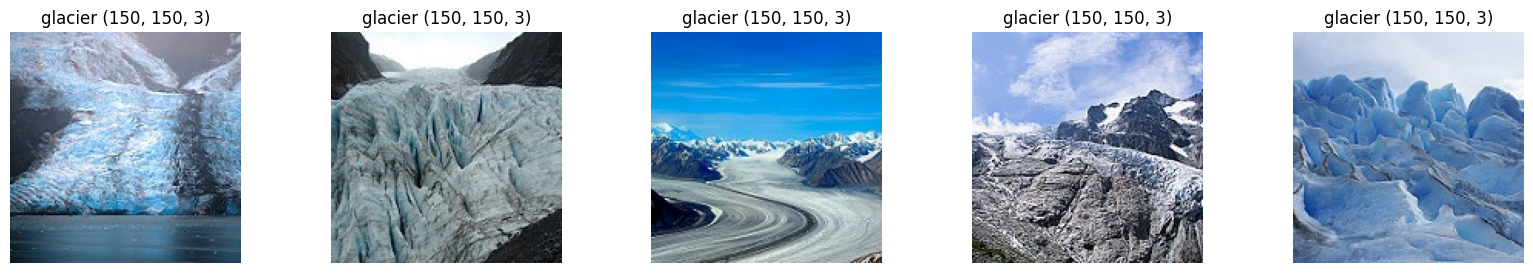

In [5]:
utils.display_images(num_images=5, target_classes='glacier')

<span style="color:red"> 

**Comments**

- The model generally did a better job in general compared to the self-built CNN model, with `forest` and `sea` maintained to be among the best labels.
- The performance with `buildings` significantly improved to 97.48%, which was 61.78%. Even though the trouble of misclassifying buildings as street no longer exist, the model seems to mistakenly detected street as buildings.
- The issue with `mountain` label still exists with low accuracy of 77.52%, as the model misclassified it with `glacier` 96 times (18.29%).

</span>

### **VGG16 model**

Select a model to train:
1: cnn_model
2: mobilenet_model
3: vgg19_model
4: resnet50_model
vgg19_model
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 118s 332ms/step - accuracy: 0.5101 - loss: 1.4093 - val_accuracy: 0.7737 - val_loss: 0.7674
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 104s 295ms/step - accuracy: 0.7592 - loss: 0.7339 - val_accuracy: 0.7922 - val_loss: 0.6185
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 158s 451ms/step - accuracy: 0.7913 - loss: 0.6276 - val_accuracy: 0.8051 - val_loss: 0.5542
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 459ms/step - accuracy: 0.8009 - loss: 0.5702 - val_accuracy: 0.8118 - val_loss: 0.5229
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 165s 470ms/step - accuracy: 0.8113 - loss: 0.5373 - val_accuracy: 0.8190 - val_loss: 0.5024
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 170s 485ms/step - accuracy: 0.8186 - loss: 0.5180 - val_accuracy: 0.8211 - val_loss: 0.4880
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 187s 532ms/step

Model saved at models/vgg19_model.h5!
The accuracy plot of the model:



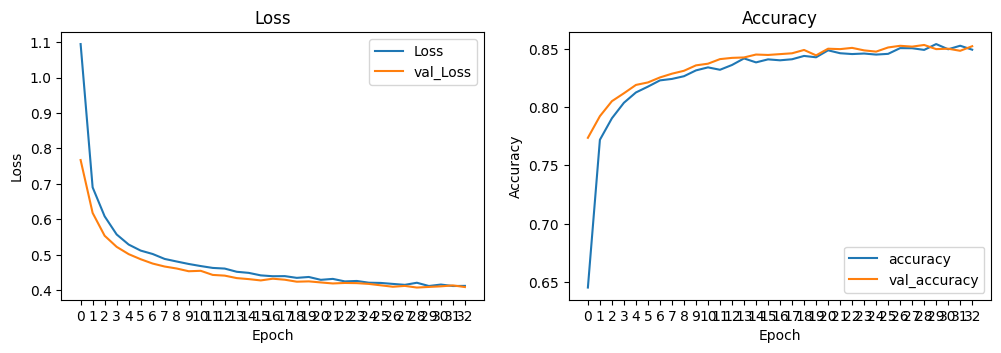

Model trained successfully!


In [7]:
# train vgg16 model
%run src/train

<span style="color:red"> 

**Comments**

The model did well, even though the accuracy does not seem to be as good as the mobile net model, it seems to have a good stability. The validation result seems to be always better than the training result over time.

</span>


**Model testing & error analysis**

Model vgg16_model loaded!
Evaluating the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 546ms/step - accuracy: 0.8600 - loss: 0.3818
Test accuracy of the model: 0.8529999852180481


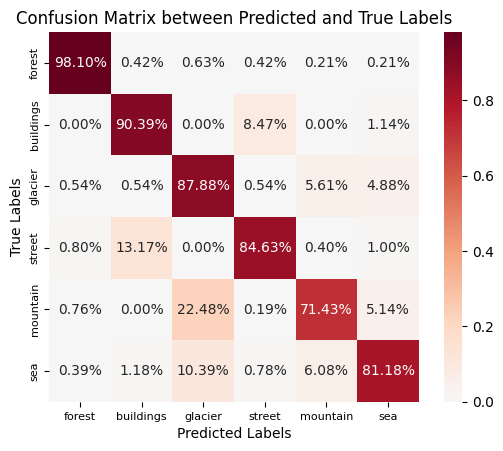

Most misclassified pair: Misclassified True Label: mountain as Predicted Label: glacier
Number of mislabeled images for mountain predicted as glacier: 118


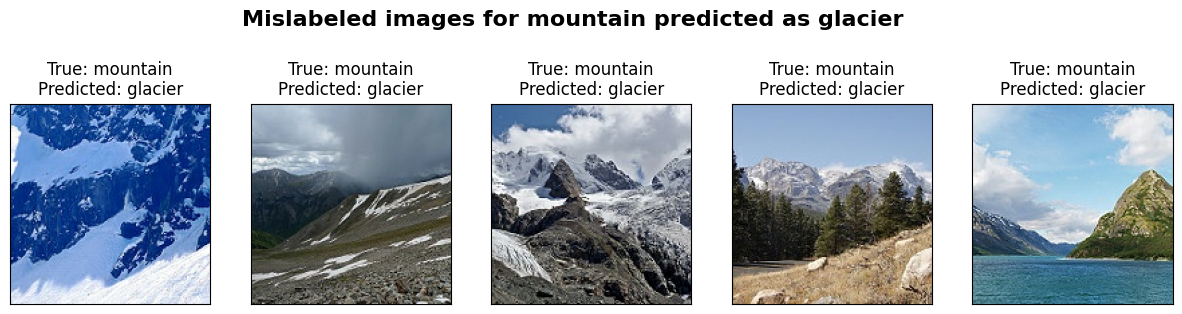

In [10]:
test_model(model_name='vgg16_model')

<span style="color:red"> 

**Comments**

- The model has the same issue with the mobile net model in predicting `mountain`, most of the errors were the misclassification with `glacier`.
- `sea` has a significantly lower accuracy, note that it misclassified 10.39% of the cases with glacier.

</span>

### **Resnet50 model**

Select a model to train:
1: cnn_model
2: mobilenet_model
3: vgg19_model
4: resnet50_model
resnet50_model
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.7433 - loss: 0.7073 - val_accuracy: 0.8881 - val_loss: 0.3061 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.8770 - loss: 0.3552 - val_accuracy: 0.8956 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.8832 - loss: 0.3219 - val_accuracy: 0.8963 - val_loss: 0.3004 - learning_rate: 0.0010
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 239ms/step - accuracy: 0.8868 - loss: 0.3129 - val_accuracy: 0.8952 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.8918 - loss: 0.3015 - val_accuracy: 0.8988 - val_loss: 0.2854 - learning_rate: 0.0010
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - accuracy: 0

Model saved at models/resnet50_model.h5!
The accuracy plot of the model:



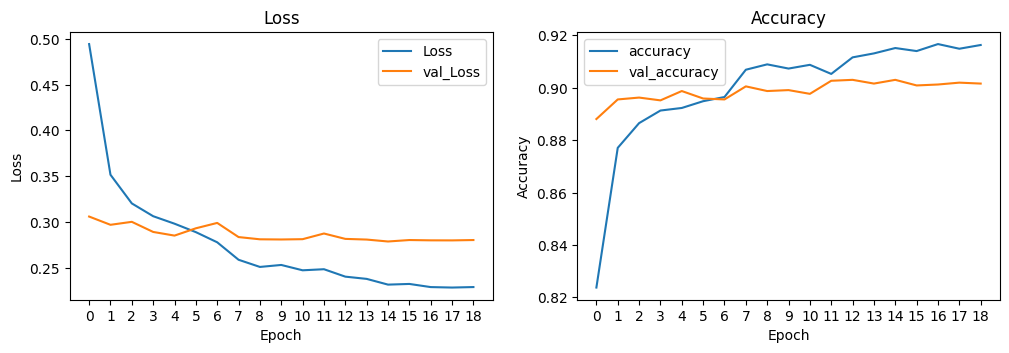

Model trained successfully!


In [3]:
# train resnet50 model
%run src/train

Model resnet50_model loaded!
Evaluating the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 331ms/step - accuracy: 0.9021 - loss: 0.2750
Test accuracy of the model: 0.9020000100135803


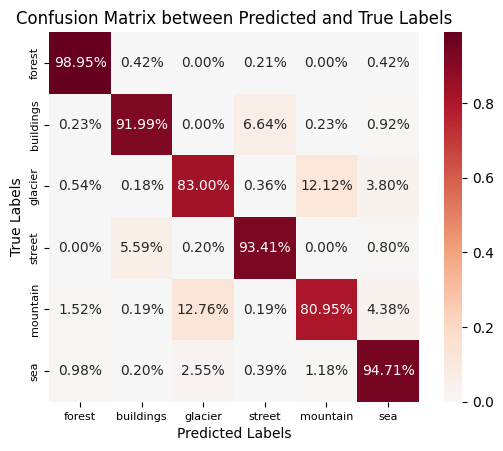

Most misclassified pair: Misclassified True Label: glacier as Predicted Label: mountain
Number of mislabeled images for glacier predicted as mountain: 67


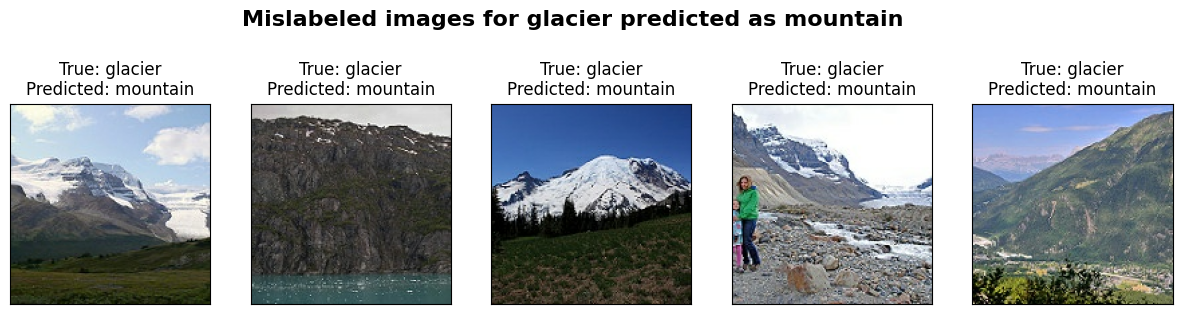

In [12]:
test_model(model_name="resnet50_model")

<span style="color:red"> 

**Comments**

- Most of the classes have a great result, `street` has its best output among the models with 93.41%.
- The model has a better performance with `mountain`, achieves 80.95% accuracy with this label, which is the best result of this class among all models.
- However, we can see that it has a worse outcome with `glacier`, only 83.00%, which is lower than other models'

</span>

## C. Model evaluation

Let's evaluate the models in detailed with different metrics. We will evaluate our models through different evaluation metrics (Accuracy, Precision, Recall, F1)

Have a quick print of the model accuracy score on the train and test set

In [ ]:
test_set = tf.data.Dataset.load('data/processed/test_set')
train_set = tf.data.Dataset.load('data/processed/train_set')
models = {
    "CNN Model": load_model('models/cnn_model.h5'),
    "MobileNet Model": load_model('models/mobilenet_model.h5'),
    "VGG16 Model": load_model('models/vgg16_model.h5'),
    "ResNet50 Model": load_model('models/resnet50_model.h5'),
}

# Create a DataFrame for accuracy scores
df = pd.DataFrame(columns=["model_name", "type", "score"])

# Iterate through models
for model_name, model in models.items():
    # Test accuracy
    y_true, y_pred = utils.extract_labels(dataset=test_set, model=model)
    test_accuracy = accuracy_score(y_true, y_pred)
    # Train accuracy
    y_true, y_pred = utils.extract_labels(dataset=train_set, model=model)
    train_accuracy = accuracy_score(y_true, y_pred)
    # Add to DataFrame
    df.loc[len(df)] = [f"{model_name}", "train_acc", round(train_accuracy, 3)]
    df.loc[len(df)] = [f"{model_name}", "test_acc", test_accuracy]

In [14]:
fig = px.bar(
    df,
    x = df['model_name'],
    y = df['score'],
    color = df['type'],
    text = df['score'],
    barmode = "group",
    title = 'Accuracy score of each model on training/test set'
)

fig.update_layout(
    yaxis = dict(
        title = "Accuracy Score",
        tick0 = 0.6,
        dtick = 0.1,
        range=[0.6, 1.0]
    ),
    xaxis = dict(title = "Model"),
    legend = dict(title = "Type")
)

<span style="color:red">

- ResNet50 model has the best accuracy score on the test set at 0.902, followed by MobileNet at 0.896. CNN model, even though has the lowest performance, has a fine score at 0.8.
- Eventhough overfit can be seen in all models, the overfitting gaps between the score on train and test set are small and can be neglected as it is normal for models to perform a bit better on seen data.

</span>

In [3]:
utils.class_report("cnn_model")

Training Set Accuracy = 0.81929
Test Set Accuracy = 0.80000 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.85148   0.97561   0.90933      1804
           1    0.84083   0.64500   0.73001      1769
           2    0.87672   0.72441   0.79332      1934
           3    0.80085   0.88895   0.84260      1909
           4    0.80366   0.78764   0.79557      2006
           5    0.76379   0.89701   0.82506      1806

    accuracy                        0.81929     11228
   macro avg    0.82289   0.81977   0.81598     11228
weighted avg    0.82289   0.81929   0.81587     11228

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.83755   0.97890   0.90272       474
           1    0.80119   0.61785   0.69767       437
           2    0.87244   0.69259   0.77218       553
           3    0.77184   0.86427   0.81544       501
           4    0.77992   0.76952   0.77469       525
  

<span style="color:red">

Training Set Performance:
- Accuracy: 81.93%.
- Highest Performance: Class 0 with high precision (85.15%) and recall (97.56%), resulting in a strong F1-score (90.93%).
- Weakest Performance: Class 1, with a recall of 64.50%, indicating many false negatives.
- Balanced metrics overall, with macro and weighted averages aligning closely.

Test Set Performance:
- Accuracy: 80.00%.
- Highest Performance: Class 0, with an F1-score of 90.27%.
- Weakest Performance: Class 1, with low recall (61.79%) and F1-score (69.77%).
- Metrics slightly drop compared to the training set, but no extreme overfitting.

Observations:
- Most classes show balanced performance between precision and recall, with Class 1 consistently underperforming.
- Minor overfitting is evident but not severe, as accuracy and F1-scores on the test set are close to the training set.

Recommendations:
- Focus on improving Class 1’s recall using techniques like data augmentation, re-sampling, or adjusting class weights.
- Explore hyperparameter tuning or additional regularization to minimize overfitting further.

</span>

In [4]:
utils.class_report("mobilenet_model")

Training Set Accuracy = 0.91450
Test Set Accuracy = 0.89600 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.98300   0.99390   0.98842      1804
           1    0.85015   0.98135   0.91105      1769
           2    0.84479   0.88935   0.86650      1934
           3    0.97540   0.85175   0.90940      1909
           4    0.90934   0.83001   0.86787      2006
           5    0.94530   0.95681   0.95102      1806

    accuracy                        0.91450     11228
   macro avg    0.91800   0.91720   0.91571     11228
weighted avg    0.91775   0.91450   0.91424     11228

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.97899   0.98312   0.98105       474
           1    0.81609   0.97483   0.88843       437
           2    0.81469   0.88246   0.84722       553
           3    0.97209   0.83433   0.89796       501
           4    0.89059   0.77524   0.82892       525
  

<span style="color:red">

Training Set Performance:  
- Accuracy: 91.45%.  
- **Highest Performance:** Class 0 with high precision (98.30%) and recall (99.39%), resulting in an F1-score of 98.84%.  
- **Weakest Performance:** Class 2, with relatively lower precision (84.48%) and F1-score (86.65%).  
- Metrics show overall strong performance with balanced precision, recall, and F1-scores across most classes.  

Test Set Performance:  
- Accuracy: 89.60%.  
- **Highest Performance:** Class 0, maintaining high precision (97.90%) and recall (98.31%) with an F1-score of 98.11%.  
- **Weakest Performance:** Class 4, with a precision of 89.06% and recall of 77.52%, leading to an F1-score of 82.89%.  
- Metrics remain close to the training set, indicating minimal overfitting.  

Observations:  
- The model performs consistently across both datasets, with slight drops in precision and recall for some classes on the test set.  
- Class 4 and Class 2 show relatively weaker recall, suggesting room for improvement.  

Recommendations:  
- Focus on enhancing recall for Class 2 and Class 4 using targeted techniques like re-sampling or fine-tuning class weights.  
- Explore advanced augmentation strategies or ensemble methods to boost overall test performance.  

</span>

In [5]:
utils.class_report("vgg16_model")

Training Set Accuracy = 0.85964
Test Set Accuracy = 0.85300 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.96909   0.97339   0.97124      1804
           1    0.85302   0.93499   0.89213      1769
           2    0.73710   0.86401   0.79552      1934
           3    0.92002   0.86171   0.88991      1909
           4    0.83558   0.71186   0.76878      2006
           5    0.87449   0.82946   0.85138      1806

    accuracy                        0.85964     11228
   macro avg    0.86488   0.86257   0.86149     11228
weighted avg    0.86343   0.85964   0.85923     11228

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.97280   0.98101   0.97689       474
           1    0.83686   0.90389   0.86909       437
           2    0.73636   0.87884   0.80132       553
           3    0.90021   0.84631   0.87243       501
           4    0.85227   0.71429   0.77720       525
  

<span style="color:red">

Training Set Performance:  
- **Accuracy:** 85.96%.  
- **Highest Performance:** Class 0 with precision (96.91%) and recall (97.34%), resulting in a high F1-score of 97.12%.  
- **Weakest Performance:** Class 4 with lower recall (71.19%) and an F1-score of 76.88%, indicating room for improvement.  
- **Observations:** The training set metrics suggest a well-performing model overall, with slight imbalances in recall for some classes.  

Test Set Performance:  
- **Accuracy:** 85.30%.  
- **Highest Performance:** Class 0 maintains strong results with an F1-score of 97.69%.  
- **Weakest Performance:** Class 4, with recall dropping to 71.43%, leading to an F1-score of 77.72%.  
- **Observations:** Metrics on the test set closely mirror the training set, indicating minimal overfitting but consistent challenges with Class 4's recall.  

Recommendations:  
- Focus on improving recall for Class 4 using techniques like oversampling or targeted data augmentation.  
- Fine-tune the model to better generalize, particularly for underperforming classes.  
- Consider class-weight adjustments during training to address imbalances in precision and recall.  

</span>

In [ ]:
utils.class_report("resnet50_model")

Training Set Accuracy = 0.92519
Test Set Accuracy = 0.90200 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.98839   0.99113   0.98976      1804
           1    0.91802   0.95591   0.93658      1769
           2    0.88040   0.86401   0.87213      1934
           3    0.95437   0.92038   0.93707      1909
           4    0.89433   0.86491   0.87937      2006
           5    0.91992   0.96678   0.94276      1806

    accuracy                        0.92519     11228
   macro avg    0.92591   0.92719   0.92628     11228
weighted avg    0.92510   0.92519   0.92488     11228

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.96502   0.98945   0.97708       474
           1    0.92414   0.91991   0.92202       437
           2    0.85000   0.83002   0.83989       553
           3    0.93042   0.93413   0.93227       501
           4    0.85170   0.80952   0.83008       525
  

### **Final conclusion**

- Among the models we used, based on the results & evaluation, the MobileNet model is the best model for the following reasons:
    - **Light (weight) - small size, fast training time**: The training time is around 165-180ms each step and only take about 10 epochs to reach its best performance. The low size also makes it faster to load the model.
    - **Accurate - High accuracy score**: The accuracy score on the test set is 0.896, which means it manage to predict 89.6% the images correctly. Even though it's not the best score, it is not very far behind the best model (0.902) and is considerably better than the other two models (VGG16, self-built CNN - 0.853,0.8)
    - **Reliability**: The evaluation proves that the model is reliable and its results can be trusted.
- Data:
    - Some mountain~glacier images are not clear and are quite difficult to distinguish by all models, and with bare tyes. It's better to have more related data of these so the model can better learn the patterns between the two labels.
- The key point that I learned from doing this project: **Balance**
    - Building a CNN model requires balancing its architecture to avoid overfitting while achieving high accuracy. The goal is to help the model learn key patterns from the training data without overfocusing on details or outliers that may mislead predictions.
    - We also need to make sure the model has enough layers so it can cover the data but not to many and too large to avoid overcomplexity and heavy model size (which can significantly waste time and computational resources).

### References
Artificial Intelligence for Text & Vision course, Macquarie University, part of my Master in Data Science degree.

Keras documentation page   
https://keras.io/api/applications/

Normalize data   
https://stackoverflow.com/questions/63572451/normalizing-batchdataset-in-tensorflow-2-3

Generate confusion matrix from prefetched data   
https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matrix

References for model building, mislabeled image generation   
https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras

Hyperparameter tuning   
https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t   
https://stackoverflow.com/questions/71255862/why-do-we-use-maxpooling-2x2-can-we-use-any-other-size-like-3x3-or-5x5-and-how#:~:text=Obviously%20(2%2C2%2C1,a%20better%20option%20to%20choose.   
https://stackoverflow.com/questions/65023353/difference-between-keras-metrics-accuracy-and-accuracy

Better understanding overfitting of Conv models   
https://www.analyticsvidhya.com/blog/2024/04/understanding-overfitting-in-convnets/#